# Predicting Diabetes Using BRFSS Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, precision_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import make_scorer

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('Diabetes_2022.csv')

In [4]:
y = df.Diabetes_01
X = df.drop(['Diabetes_01'], axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [6]:
print('X_train:', X_train.shape, 'X_test:', X_test.shape)
print('y_train:', y_train.shape, 'y_test:', y_test.shape)

X_train: (228311, 24) X_test: (57078, 24)
y_train: (228311,) y_test: (57078,)


### SMOTE

In [7]:
smote = SMOTE(random_state=2)
X_smote_sampled, y_smote_sampled = smote.fit_resample(X_train, y_train)

print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(y_smote_sampled)))


Original dataset shape Counter({0: 192370, 1: 35941})
Resampled dataset shape Counter({0: 192370, 1: 192370})


## Modeling

In [8]:
def optimize_model(model, param_grid, primary_metric="recall", cv=5, X_train = X_train, y_train = y_train):
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'recall': make_scorer(recall_score)
    }
    optimizer = GridSearchCV(estimator=model, 
                             param_grid=param_grid, 
                             scoring=scoring, 
                             refit=primary_metric, 
                             cv=cv, 
                             n_jobs=-1, 
                             verbose=True)
    
    optimizer.fit(X_train, y_train)
    print('Best parameters found:')
    print(optimizer.best_params_)
    print(f'\nBest {primary_metric} score: %0.6f' % (optimizer.best_score_))

    if primary_metric == 'recall':
        print(f"Corresponding accuracy: {optimizer.cv_results_['mean_test_accuracy'][optimizer.best_index_]:0.6f}")
    else:
        print(f"Corresponding recall: {optimizer.cv_results_['mean_test_recall'][optimizer.best_index_]:0.6f}")
    
    return optimizer.best_estimator_

In [9]:
def evaluate_model(model, X_test = X_test, y_test = y_test):
    y_pred = model.predict(X_test)
    print('\nClassification report: ')
    print(classification_report(y_test, y_pred))

### Logistic Regression

In [10]:
lr_baseline = LogisticRegression(random_state = 0)
lr_baseline.fit(X_smote_sampled, y_smote_sampled)
print('Best score:', np.round(accuracy_score(y_test, lr_baseline.predict(X_test)), 6))
evaluate_model(lr_baseline)

Best score: 0.702617

Classification report: 
              precision    recall  f1-score   support

           0       0.92      0.71      0.80     48132
           1       0.30      0.66      0.41      8946

    accuracy                           0.70     57078
   macro avg       0.61      0.69      0.61     57078
weighted avg       0.82      0.70      0.74     57078



In [11]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 0.1, 1, 10,100],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [100, 200]
}
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score)
}
grid_search = GridSearchCV(estimator=lr_baseline, param_grid=param_grid, scoring=scoring, refit='recall', cv=5)
grid_search.fit(X_smote_sampled, y_smote_sampled)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
best_recall_score = grid_search.best_score_
print("Best Recall Score (used for refit):", best_recall_score)
best_index = grid_search.best_index_  
best_accuracy_score = grid_search.cv_results_['mean_test_accuracy'][best_index]
print("Best Accuracy Score:", best_accuracy_score)

Best Parameters: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Recall Score (used for refit): 0.7262307012527941
Best Accuracy Score: 0.717993969953735


In [12]:
lr_model = grid_search.best_estimator_ 

<Figure size 200x100 with 0 Axes>

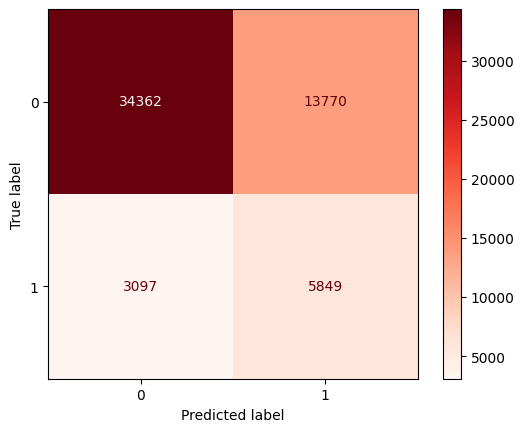

In [13]:
y_pred = lr_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(2, 1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.show()


### Decision Tree Classifier

In [14]:
tree_model = Pipeline([("scaler", StandardScaler()), ("model", DecisionTreeClassifier())])

tree_param_grid = {'model__criterion': ['gini', 'entropy'],
                   'model__max_depth': [2, 5, 10, 20, 30],
                   'model__min_samples_leaf': [5, 10, 20, 30]}

In [15]:
tree_baseline = DecisionTreeClassifier(random_state = 0)
tree_baseline.fit(X_smote_sampled, y_smote_sampled)
print('Best score:', np.round(accuracy_score(y_test, tree_baseline.predict(X_test)), 6))
evaluate_model(tree_baseline)

Best score: 0.710869

Classification report: 
              precision    recall  f1-score   support

           0       0.88      0.76      0.82     48132
           1       0.25      0.44      0.32      8946

    accuracy                           0.71     57078
   macro avg       0.57      0.60      0.57     57078
weighted avg       0.78      0.71      0.74     57078



In [16]:
tree_model = optimize_model(tree_model, tree_param_grid)
evaluate_model(tree_model)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found:
{'model__criterion': 'entropy', 'model__max_depth': 30, 'model__min_samples_leaf': 5}

Best recall score: 0.256949
Corresponding accuracy: 0.815453

Classification report: 
              precision    recall  f1-score   support

           0       0.87      0.92      0.89     48132
           1       0.38      0.26      0.31      8946

    accuracy                           0.82     57078
   macro avg       0.62      0.59      0.60     57078
weighted avg       0.79      0.82      0.80     57078



In [21]:
tree_model = Pipeline([("scaler", StandardScaler()), ("model", DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf=3))])
tree_param_grid = {'model__max_depth': np.arange(100,125,1)}
tree_model = optimize_model(tree_model, tree_param_grid)
evaluate_model(tree_model)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters found:
{'model__max_depth': 124}

Best recall score: 0.281489
Corresponding accuracy: 0.803457

Classification report: 
              precision    recall  f1-score   support

           0       0.87      0.90      0.89     48132
           1       0.35      0.28      0.31      8946

    accuracy                           0.81     57078
   macro avg       0.61      0.59      0.60     57078
weighted avg       0.79      0.81      0.80     57078



<Figure size 200x100 with 0 Axes>

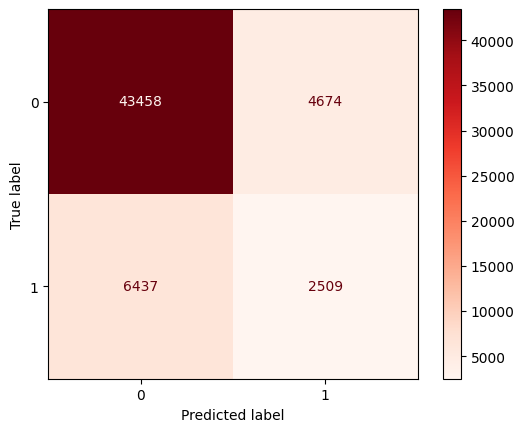

In [22]:
y_pred = tree_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(2, 1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.show()

### XGBoost Classifier

In [23]:
xgb_classifier = xgb.XGBClassifier(eval_metric='error', random_state = 0)
xgb_classifier.fit(X_smote_sampled, y_smote_sampled)
print('Best score:', np.round(accuracy_score(y_test, xgb_classifier.predict(X_test)), 6))
evaluate_model(xgb_classifier)

Best score: 0.706489

Classification report: 
              precision    recall  f1-score   support

           0       0.92      0.72      0.80     48132
           1       0.30      0.65      0.41      8946

    accuracy                           0.71     57078
   macro avg       0.61      0.68      0.61     57078
weighted avg       0.82      0.71      0.74     57078



<Figure size 200x100 with 0 Axes>

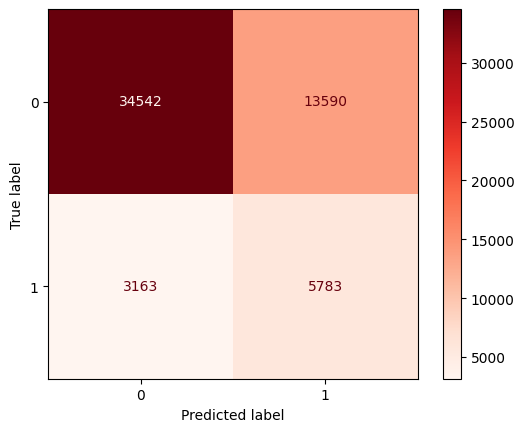

In [24]:
y_pred = xgb_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(2, 1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.show()

## Metrics

In [25]:
from sklearn import metrics
model_name = []
accuracy_score = []
f1_score = []
roc_auc_score = []
recall_score = []
precision_score = []
    
def metrics_models(name, model, X_test = X_test, y_test = y_test):
    models = list()
    models.append((name, model))
    
    for name, model in models:
        model_name.append(name)
        accuracy_score.append(metrics.accuracy_score(y_test, model.predict(X_test)))
        f1_score.append(metrics.f1_score(y_test, model.predict(X_test)))
        roc_auc_score.append(metrics.roc_auc_score(y_test, model.predict(X_test)))
        recall_score.append(metrics.recall_score(y_test, model.predict(X_test)))
        precision_score.append(metrics.precision_score(y_test, model.predict(X_test)))


In [26]:
metrics_models('Base LinearRegression (Smote Oversample)', lr_baseline)
metrics_models('LinearRegression (Smote Oversample)', lr_model)
metrics_models('Base DecisionTreeClassifier (Smote Oversample)', tree_baseline)
metrics_models('DecisionTreeClassifier (Smote Oversample)', tree_model)
metrics_models('XGBoostClassifier (Smote Oversample)', xgb_classifier)

In [27]:
metric_df_smote = pd.DataFrame({'Model': model_name,
                           'Accuracy': accuracy_score,
                           'F1-score': f1_score,
                           'AUC': roc_auc_score,
                           'Recall': recall_score,
                           'Precision': precision_score})

In [28]:
metric_df_smote

,Model,Accuracy,F1-score,AUC,Recall,Precision
0,Base LinearRegression (Smote Oversample),0.702617,0.410379,0.685389,0.660295,0.297702
1,LinearRegression (Smote Oversample),0.704492,0.409522,0.683862,0.653812,0.298129
2,Base DecisionTreeClassifier (Smote Oversample),0.710869,0.322342,0.600096,0.438744,0.254754
3,DecisionTreeClassifier (Smote Oversample),0.805337,0.311117,0.591676,0.280461,0.349297
4,XGBoostClassifier (Smote Oversample),0.706489,0.408418,0.682043,0.646434,0.298508


Linear Regression Models:
Compared to random oversampling, SMOTE slightly lowered the recall (e.g., 0.6603 vs. 0.7383 for Base LinearRegression), but the overall performance metrics remained comparable. Precision remains a challenge, with no significant improvement.

XGBoostClassifier:
Similar to the linear regression models, recall is slightly lower with SMOTE (0.6464 vs. 0.7489 with random oversampling). The precision and F1-scores are also in the same range. SMOTE may have helped create more balanced decision boundaries, but the overall improvement isn't drastic compared to random oversampling.
DecisionTreeClassifier Models:

Decision tree models continue to underperform in both oversampling strategies. Their recall and AUC scores indicate that more sophisticated approaches (e.g., hyperparameter tuning or a different model altogether) may be necessary for these models.